# Compressing Context in LangGraph

*Compressing context involves retaining only the tokens required to perform a task.*

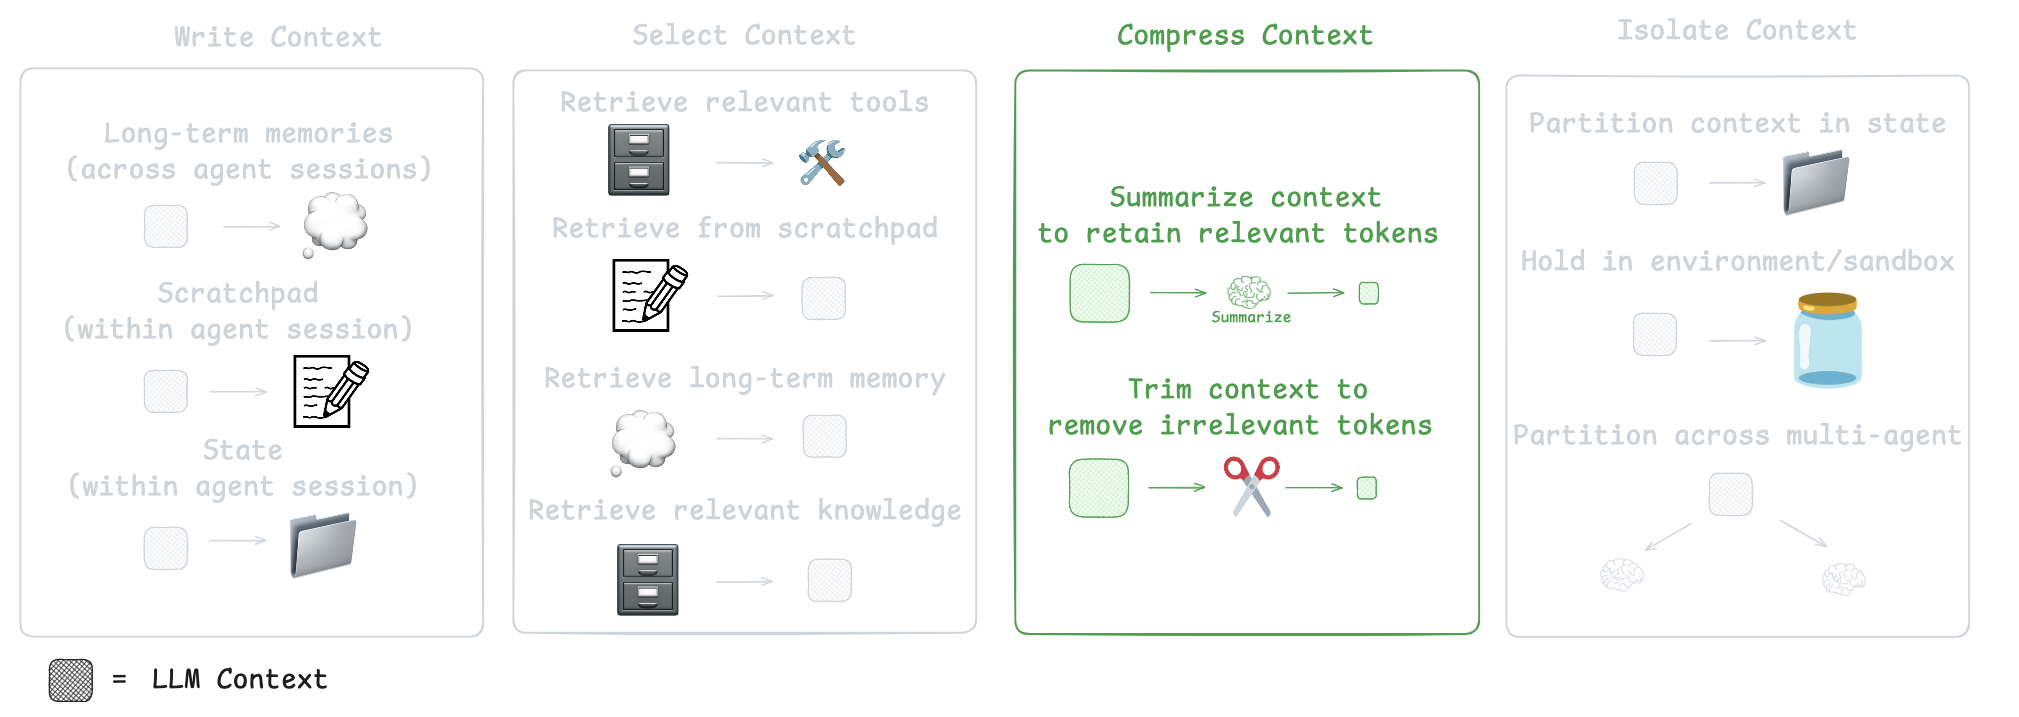

## Summarization 

Agent interactions can span [hundreds of turns](https://www.anthropic.com/engineering/built-multi-agent-research-system) and use token-heavy tool calls. Summarization is one common way to manage these challenges. If you’ve used Claude Code, you’ve seen this in action. Claude Code runs “[auto-compact](https://docs.anthropic.com/en/docs/claude-code/costs)” after you exceed 95% of the context window and it will summarize the full trajectory of user-agent interactions. This type of compression across an [agent trajectory](https://langchain-ai.github.io/langgraph/concepts/memory/#manage-short-term-memory) can use various strategies such as [recursive](https://arxiv.org/pdf/2308.15022#:~:text=the%20retrieved%20utterances%20capture%20the,based%203) or [hierarchical](https://alignment.anthropic.com/2025/summarization-for-monitoring/#:~:text=We%20addressed%20these%20issues%20by,of%20our%20computer%20use%20capability) summarization.

It can also be useful to [add summarization](https://github.com/langchain-ai/open_deep_research/blob/e5a5160a398a3699857d00d8569cb7fd0ac48a4f/src/open_deep_research/utils.py#L1407) at points in an agent’s trajectory. For example, it can be used to post-process certain tool calls (e.g., token-heavy search tools). As a second example, [Cognition](https://cognition.ai/blog/dont-build-multi-agents#a-theory-of-building-long-running-agents) mentioned summarization at agent-agent boundaries to knowledge hand-off. They also the challenge if specific events or decisions to be captured. They use a fine-tuned model for this in Devin, which underscores how much work can go into this step.

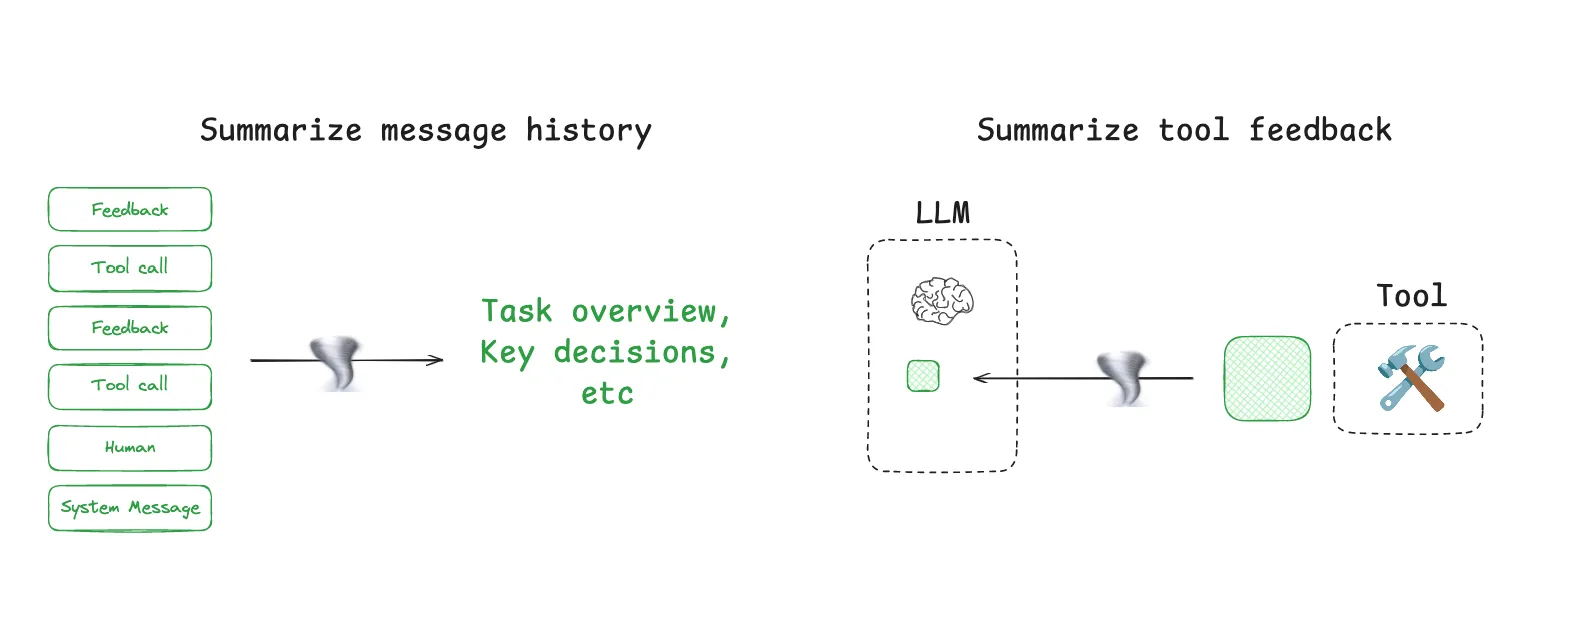

### Summarization in LangGraph

Because LangGraph is a low [is a low-level orchestration framework](https://blog.langchain.com/how-to-think-about-agent-frameworks/), you can [lay out your agent as a set of nodes](https://www.youtube.com/watch?v=aHCDrAbH_go), [explicitly define](https://blog.langchain.com/how-to-think-about-agent-frameworks/) the logic within each one, and define an state object that is passed between them. This low-level control gives several ways to compress context.

You can use a message list as your agent state and [summarize](https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#manage-short-term-memory) using [a few built-in utilities](https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#manage-short-term-memory).

#### Summarize Messages

Let's implement a RAG agent, and add summarization of the conversation history.

In [5]:
import getpass
import os

from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.embeddings import init_embeddings

def _set_env(var: str) -> None:
    """Set environment variable if not already set."""
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# Set up environment and initialize model
_set_env("OPENAI_API_KEY")

# Define URLs for document loading
urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

# Load documents from the specified URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents into manageable chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000,
    chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Create embeddings and vectorstore
embeddings = init_embeddings("openai:text-embedding-3-small")
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, 
    embedding=embeddings
)
retriever = vectorstore.as_retriever()

# Create retriever tool for the agent
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

# Test the retriever tool
test_result = retriever_tool.invoke({"query": "types of reward hacking"})

In [6]:
from langchain.chat_models import init_chat_model

# Initialize the language model
llm = init_chat_model("openai:gpt-5", temperature=0)

# Set up tools and bind them to the LLM
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Bind tools to LLM for agent functionality
llm_with_tools = llm.bind_tools(tools)

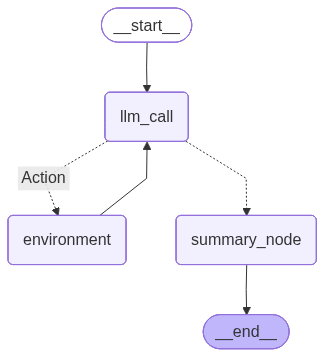

In [7]:
from typing_extensions import Literal

from IPython.display import Image, display
from langchain_core.messages import SystemMessage, ToolMessage
from langgraph.graph import END, START, MessagesState, StateGraph


# Define extended state with summary field
class State(MessagesState):
    """Extended state that includes a summary field for context compression."""
    summary: str


# Define the RAG agent system prompt
rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng. 
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

# Define the summarization prompt
summarization_prompt = """Summarize the full chat history and all tool feedback to 
give an overview of what the user asked about and what the agent did."""


def llm_call(state: MessagesState) -> dict:
    """Execute LLM call with system prompt and message history.
    
    Args:
        state: Current conversation state
        
    Returns:
        Dictionary with new messages
    """
    messages = [SystemMessage(content=rag_prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def tool_node(state: MessagesState) -> dict:
    """Execute tool calls and return results.
    
    Args:
        state: Current conversation state with tool calls
        
    Returns:
        Dictionary with tool results
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def summary_node(state: MessagesState) -> dict:
    """Generate a summary of the conversation and tool interactions.
    
    Args:
        state: Current conversation state
        
    Returns:
        Dictionary with conversation summary
    """
    messages = [SystemMessage(content=summarization_prompt)] + state["messages"]
    result = llm.invoke(messages)
    return {"summary": result.content}


def should_continue(state: MessagesState) -> Literal["Action", "summary_node"]:
    """Determine next step based on whether LLM made tool calls.
    
    Args:
        state: Current conversation state
        
    Returns:
        Next node to execute
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # If LLM made tool calls, execute them
    if last_message.tool_calls:
        return "Action"
    # Otherwise, proceed to summarization
    return "summary_node"


# Build the RAG agent workflow
agent_builder = StateGraph(State)

# Add nodes to the workflow
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)
agent_builder.add_node("summary_node", summary_node)

# Define the workflow edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "Action": "environment",
        "summary_node": "summary_node",
    },
)
agent_builder.add_edge("environment", "llm_call")
agent_builder.add_edge("summary_node", END)

# Compile the agent
agent = agent_builder.compile()

# Display the agent workflow
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [8]:
from utils import format_messages, format_message

In [9]:
query = "Why does RL improve LLM reasoning according to the blogs?"
result = agent.invoke({"messages": query})
format_message(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Why does RL improve LLM reasoning according to the blogs?                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Great question. Before I pull sources, could you clarify the scope you want?                                    │
│                                                                                                                 │
│ - Are you referring to Lilian Weng’s posts on RLHF and RL fine-tuning for reasoning (e.g., RL from human/AI     │
│ feedback, process/scratchpad rewards, verifier/rejection sampling loops)?                                       │
│ - Do you want a concise, high-level explanation, or a post-by-post synthesis with citations and key evidence?   │
│ - Any time window (e.g., her 2022–2024 posts) or specific posts you have in mind?                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
from rich.markdown import Markdown
Markdown(result["summary"])

 • User asked: Why do blogs say RL improves LLM reasoning?                                                         
 • Agent actions: Sought clarification on scope and sources, asking whether the user meant posts like Lilian Weng’s
   on RLHF and RL for reasoning, preferred a concise vs detailed synthesis with citations, and any specific time   
   window or posts.                                                                                                
 • Tools used: None.

Nice, but it uses `115k tokens`!

See trace:  

https://smith.langchain.com/public/50d70503-1a8e-46c1-bbba-a1efb8626b05/r

This is often a challenge with agents that have token-heavy tool calls!

#### Summarize Tools

Let's update the RAG agent, and add summarization the tool call output.

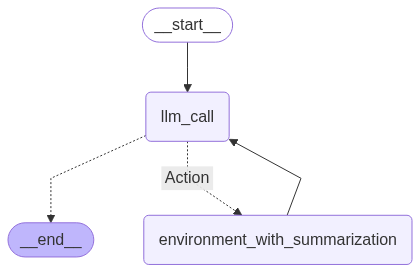

In [11]:
tool_summarization_prompt = """You will be provided a doc from a RAG system.
Summarize the docs, ensuring to retain all relevant / essential information.
Your goal is simply to reduce the size of the doc (tokens) to a more manageable size."""

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

def tool_node_with_summarization(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        # Summarize the doc
        summary = llm.invoke([{"role":"system",
                              "content":tool_summarization_prompt},
                              {"role":"user",
                               "content":observation}])
        result.append(ToolMessage(content=summary.content, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment_with_summarization", tool_node_with_summarization)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment_with_summarization",
        END: END,
    },
)
agent_builder.add_edge("environment_with_summarization", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [12]:
from utils import format_messages

query = "Why does RL improve LLM reasoning according to the blogs?"
result = agent.invoke({"messages": query})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Why does RL improve LLM reasoning according to the blogs?                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To make sure I pull the right material: are you asking specifically about Lilian Weng’s blog posts (e.g., RLHF, │
│ RL for reasoning/agents), and would you like a concise synthesis or a more detailed, citation-backed summary    │
│ with references to specific posts and sections?                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

This uses 60k tokens. 

https://smith.langchain.com/public/994cdf93-e837-4708-9628-c83b397dd4b5/r

#### Learn More

* **Heuristic Compression and Message Trimming** - https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#trim-messages

LangGraph provides several message management strategies to handle context window limitations. The `trim_messages()` function allows you to limit token count by keeping the "last" messages and controlling maximum tokens and message boundaries. This can be implemented as pre-model hooks for agents with custom state management. Key benefits include preventing context window overflow, maintaining conversation context, optimizing memory usage, and enabling long-running conversations. The approach emphasizes flexible, programmatic management of conversational memory across different AI interaction scenarios.

* **SummarizationNode as Pre-Model Hook** - https://langchain-ai.github.io/langgraph/how-tos/create-react-agent-manage-message-history/

SummarizationNode helps manage conversation history by summarizing messages when token count exceeds specified limits. It can be implemented as a pre-model hook in ReAct agents, allowing you to keep original message history or overwrite it with summaries. The node uses `count_tokens_approximately()` to track message history size and supports configurable parameters including `max_tokens` (threshold), `max_summary_tokens` (summary length), and `output_messages_key` (storage location). This approach provides flexible mechanisms for managing conversation memory in AI agents while preventing context window overflow and maintaining conversation context.

* **LangMem Summarization** - https://langchain-ai.github.io/langmem/guides/summarization/

LangMem provides strategies for managing long context through message history summarization. It offers two primary approaches: direct summarization using `summarize_messages()` function with configurable token thresholds and "running summary" maintenance, and the SummarizationNode approach with dedicated nodes for automatic summary propagation. Key implementation considerations include configuring token limits, using separate state keys for full message history versus summaries, and maintaining conversation context across multiple interactions. LangMem integrates seamlessly with LangGraph state management for both simple chatbots and ReAct-style agents.